In [ ]:
# Standard libraries
import os

# Numerical and data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image as tf_image
from tensorflow.keras import models as tf_models
from tensorflow.keras import layers as tf_layers
from tensorflow.keras import optimizers as tf_optimizers

# Scikit-learn
from sklearn.utils import class_weight
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.preprocessing import StandardScaler, LabelBinarizer


In [4]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet152V2


In [5]:
# Load and preprocess data from Excel files
def load_and_preprocess_image(base_dir, path, target_size):
    img_path = os.path.join(base_dir, path.replace('\\', '/'))
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    preprocessed_img = tf.keras.applications.resnet_v2.preprocess_input(img_array)
    return preprocessed_img

def get_data_for_training(excel_path, base_dir, image_size=(64, 64)):
    df = pd.read_excel(excel_path)
    df = df.dropna(subset=['image_path'])
    class_names = df.columns[2:]  # Assuming class columns start from the 3rd column
    X = np.array([load_and_preprocess_image(base_dir, path, image_size) for path in df['image_path'].values])
    y = df[class_names].values
    return X, y, df['image_path'].values

training_dir = "/kaggle/input/dataset/Dataset/training"
validation_dir = "/kaggle/input/dataset/Dataset/validation"

train_excel_path = "/kaggle/input/dataset/Dataset/training/training_data.xlsx"
val_excel_path = "/kaggle/input/dataset/Dataset/validation/validation_data.xlsx"
base_dir = "/kaggle/input/dataset/Dataset"

# Load the training and validation data
X_train, y_train, _ = get_data_for_training(train_excel_path, base_dir, image_size=(64, 64))
X_val, y_val, image_paths = get_data_for_training(val_excel_path, base_dir, image_size=(64, 64))

In [6]:
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_train: {X_val.shape}, y_train: {y_val.shape}")


X_train: (37607, 64, 64, 3), y_train: (37607, 10)
X_train: (16132, 64, 64, 3), y_train: (16132, 10)


In [7]:
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 32
NUM_EPOCHS = 50
IMAGE_SIZE = 64
INPUT_SHAPE = (64, 64, 3)

In [ ]:
class_names = ['Angioectasia', 'Bleeding', 'Erosion', 'Erythema', 'Foreign Body', 'Lymphangiectasia', 'Normal', 'Polyp', 'Ulcer', 'Worms']

In [ ]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import layers, callbacks, optimizers, losses, metrics, Model
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

INPUT_SHAPE = (64, 64, 3)
NUM_CLASSES = len(class_names)


# Define the ResNet152V2 model configuration
def create_resnet152v2_classifier(input_shape, num_classes):
    resnet_base = ResNet152V2(
        include_top=False,  
        weights="imagenet",  
        input_shape=input_shape,
        pooling='avg',  
    )
 
    model = tf.keras.models.Sequential([
        layers.Input(shape=input_shape),
        resnet_base,
        layers.Dropout(0.2),
        layers.Dense(2048, activation="gelu",kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(1024, activation="gelu",kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.2),
        layers.Dense(512, activation="gelu"),
        layers.Dropout(0.2),
        layers.Dense(256, activation="gelu"),
        layers.Dense(num_classes, activation="softmax")  
    ], name='ResNet152V2_Classifier')

    return model


# Instantiate the ResNet152V2 model
with tf.device('/gpu:0'):
    resnet_model = create_resnet152v2_classifier(
        input_shape=INPUT_SHAPE,
        num_classes=NUM_CLASSES
    )

    # Define callbacks for training
    lr_callback = callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=5,
        mode="auto",
        min_delta=0.0001,
        restore_best_weights=True
    )
    
    es_transfer = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,  # Stop after 10 epochs of no improvement
    restore_best_weights=True
    )
    
    # EarlyStopping for Partial Fine-Tuning (Unfreeze Top Layers)
    es_partial_fine_tune = callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=12,  # Allow slightly more room for improvement
        restore_best_weights=True
    )
    
    # EarlyStopping for Full Fine-Tuning (Unfreeze Entire Base Model)
    es_full_fine_tune = callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15,  # Allow more patience for the fine-tuning phase
        restore_best_weights=True
    )

    checkpoint_filepath = '/kaggle/working/CheckPoints/ResNet152V2/modellast.weights.h5'
    
    chk_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=False,
        save_weights_only=True,  
        mode='auto',
        verbose=1
    )


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
resnet_model.summary()

Model: "ResNet152V2_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 2048)           │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,284,874 (249.04 MB)

 Trainable params: 65,141,130 (248.49 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [ ]:
# First Phase: Train with resnet_base.trainable = False
LEARNING_RATE = 1e-3
with tf.device('/gpu:0'):
    # Freeze the ResNet base model
    resnet_model.layers[0].trainable = False  
    resnet_model.compile(
        optimizer=optimizers.Adamax(learning_rate=LEARNING_RATE),
        loss=losses.CategoricalCrossentropy(from_logits=False),
        metrics=[metrics.CategoricalAccuracy(name='accuracy')]
    )
    print("Phase 1: Training with Frozen Base Model")
    history_phase1 = resnet_model.fit(
        x=X_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=30,  
        validation_data=(X_val, y_val),
        callbacks=[lr_callback, es_transfer, chk_callback] 
    )

Phase 1: Training with Frozen Base Model
Epoch 1/30


I0000 00:00:1732199487.125340      98 service.cc:145] XLA service 0x7858f4004660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732199487.125393      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   5/1176 ━━━━━━━━━━━━━━━━━━━━ 36s 31ms/step - accuracy: 0.5456 - loss: 5.8053 

I0000 00:00:1732199500.862126      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7592 - loss: 3.1278
Epoch 1: saving model to /kaggle/working/CheckPoints/ResNet152V2/modellast.weights.h5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 103s 63ms/step - accuracy: 0.7592 - loss: 3.1273 - val_accuracy: 0.7936 - val_loss: 1.8017 - learning_rate: 0.0010
Epoch 2/30
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7991 - loss: 1.6168
Epoch 2: saving model to /kaggle/working/CheckPoints/ResNet152V2/modellast.weights.h5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - accuracy: 0.7991 - loss: 1.6166 - val_accuracy: 0.8094 - val_loss: 1.1845 - learning_rate: 0.0010
Epoch 3/30
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8094 - loss: 1.0972
Epoch 3: saving model to /kaggle/working/CheckPoints/ResNet152V2/modellast.weights.h5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 47s 40ms/step - accuracy: 0.8094 - loss: 1.0971 - val_accuracy: 0.8155 - val_loss: 0.9259 - learning_rate: 0.0010
Epoch 4/30
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/

In [ ]:
# Recreate the model architecture
resnet_model = create_resnet152v2_classifier(
    input_shape=INPUT_SHAPE,
    num_classes=NUM_CLASSES
)

# Load saved weights from the checkpoint
checkpoint_filepath = '/kaggle/working/CheckPoints/ResNet152V2/modellast.weights.h5'
resnet_model.load_weights(checkpoint_filepath)
print("Loaded model weights from checkpoint.")


Loaded model weights from checkpoint.


In [14]:
resnet_model.summary()

Model: "ResNet152V2_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)        │ (None, 2048)           │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,284,874 (249.04 MB)

 Trainable params: 65,141,130 (248.49 MB)

 Non-trainable params: 143,744 (561.50 KB)

In [ ]:
# Second phase: Partial Fine-Tuning (Unfreeze Higher Layers)
resnet_base = resnet_model.layers[0] 

LEARNING_RATE = 1e-4
with tf.device('/gpu:0'):

    for layer in resnet_base.layers[-60:]:
        layer.trainable = True
    
    for layer in resnet_base.layers[:-60]:
        layer.trainable = False

    resnet_model.compile(
        optimizer=optimizers.Adamax(learning_rate=LEARNING_RATE),
        loss=losses.CategoricalCrossentropy(from_logits=False),
        metrics=[metrics.CategoricalAccuracy(name='accuracy')]
    )
    
    print("Step 2: Partial Fine-Tuning with Top Layers Unfrozen")
    history_partial_finetune = resnet_model.fit(
        x=X_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=20, 
        validation_data=(X_val, y_val),
        callbacks=[lr_callback, es_partial_fine_tune, chk_callback]  
    )



Step 2: Partial Fine-Tuning with Top Layers Unfrozen
Epoch 1/20
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7814 - loss: 0.8870
Epoch 1: saving model to /kaggle/working/CheckPoints/ResNet152V2/modellast.weights.h5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 124s 73ms/step - accuracy: 0.7814 - loss: 0.8869 - val_accuracy: 0.8259 - val_loss: 0.6878 - learning_rate: 1.0000e-04
Epoch 2/20
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8476 - loss: 0.5987
Epoch 2: saving model to /kaggle/working/CheckPoints/ResNet152V2/modellast.weights.h5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.8476 - loss: 0.5987 - val_accuracy: 0.8367 - val_loss: 0.6594 - learning_rate: 1.0000e-04
Epoch 3/20
1175/1176 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8785 - loss: 0.4927
Epoch 3: saving model to /kaggle/working/CheckPoints/ResNet152V2/modellast.weights.h5
1176/1176 ━━━━━━━━━━━━━━━━━━━━ 59s 50ms/step - accuracy: 0.8785 - loss: 0.4927 - val_accuracy: 0.8408 - val_loss: 0.6605 - 

In [ ]:
# Third Phase: Train with resnet_base.trainable = True
LEARNING_RATE = 5e-6
with tf.device('/gpu:0'):
    resnet_model.layers[0].trainable = True 
    resnet_model.compile(
        optimizer=optimizers.Adamax(learning_rate=LEARNING_RATE),
        loss=losses.CategoricalCrossentropy(from_logits=False),
        metrics=[metrics.CategoricalAccuracy(name='accuracy')]
    )
    print("Phase 2: Fine-Tuning with Unfrozen Base Model")
    history_phase2 = resnet_model.fit(
        x=X_train,
        y=y_train,
        batch_size=16,
        epochs=25,  
        validation_data=(X_val, y_val),
        callbacks=[lr_callback, es_full_fine_tune, chk_callback]  
    )

Phase 2: Fine-Tuning with Unfrozen Base Model
Epoch 1/25
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9726 - loss: 0.1824
Epoch 1: saving model to /kaggle/working/CheckPoints/ResNet152V2/modellast.weights.h5
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 159s 52ms/step - accuracy: 0.9726 - loss: 0.1824 - val_accuracy: 0.8518 - val_loss: 1.0355 - learning_rate: 5.0000e-06
Epoch 2/25
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9757 - loss: 0.1729
Epoch 2: saving model to /kaggle/working/CheckPoints/ResNet152V2/modellast.weights.h5
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 97s 41ms/step - accuracy: 0.9757 - loss: 0.1729 - val_accuracy: 0.8517 - val_loss: 1.0585 - learning_rate: 5.0000e-06
Epoch 3/25
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9763 - loss: 0.1709
Epoch 3: saving model to /kaggle/working/CheckPoints/ResNet152V2/modellast.weights.h5
2351/2351 ━━━━━━━━━━━━━━━━━━━━ 97s 41ms/step - accuracy: 0.9763 - loss: 0.1709 - val_accuracy: 0.8523 - val_loss: 1.0560 - learnin

In [ ]:
 # Predict on the validation set
y_pred = resnet_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Save validation predictions to an Excel file
results_df = pd.DataFrame({
    'Image_path': image_paths,
    'actual_class': y_val_classes, 
    'predicted_class': y_pred_classes
})

results_file_path = os.path.join('/kaggle/working', "results.xlsx")
results_df.to_excel(results_file_path, index=False, sheet_name='Sheet1')

print(f"Results saved to: {results_file_path}")

505/505 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step
Results saved to: /kaggle/working/results.xlsx


In [ ]:
print("Confusion Matrix:")
cm = confusion_matrix(y_val_classes, y_pred_classes, normalize='true')
print(cm)

Confusion Matrix:
[[5.81488934e-01 8.04828974e-03 1.06639839e-01 1.00603622e-02
  8.04828974e-03 1.20724346e-02 2.35412475e-01 3.62173038e-02
  0.00000000e+00 2.01207243e-03]
 [2.50696379e-02 5.76601671e-01 1.14206128e-01 2.50696379e-02
  8.35654596e-03 8.35654596e-03 2.11699164e-01 3.06406685e-02
  0.00000000e+00 0.00000000e+00]
 [5.02164502e-02 3.37662338e-02 4.76190476e-01 4.06926407e-02
  2.85714286e-02 1.90476190e-02 2.85714286e-01 5.36796537e-02
  6.92640693e-03 5.19480519e-03]
 [2.69360269e-02 2.35690236e-02 2.89562290e-01 2.72727273e-01
  1.68350168e-02 3.36700337e-03 2.76094276e-01 9.09090909e-02
  0.00000000e+00 0.00000000e+00]
 [1.17647059e-02 0.00000000e+00 5.58823529e-02 8.82352941e-03
  7.44117647e-01 2.05882353e-02 1.47058824e-01 8.82352941e-03
  0.00000000e+00 2.94117647e-03]
 [3.20699708e-02 1.45772595e-02 8.74635569e-02 8.74635569e-03
  3.20699708e-02 6.15160350e-01 1.80758017e-01 2.91545190e-02
  0.00000000e+00 0.00000000e+00]
 [5.77846504e-03 2.60437861e-03 2.132334

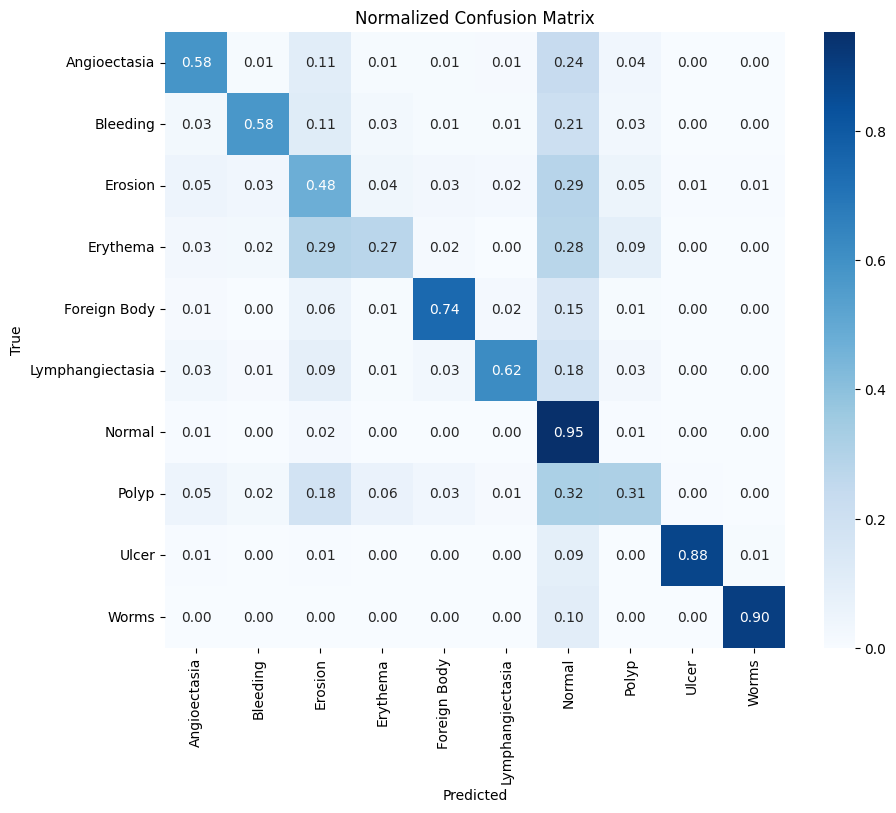

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()


In [20]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_val_classes, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.58      0.59       497
           1       0.67      0.58      0.62       359
           2       0.49      0.48      0.48      1155
           3       0.39      0.27      0.32       297
           4       0.70      0.74      0.72       340
           5       0.72      0.62      0.66       343
           6       0.93      0.95      0.94     12287
           7       0.42      0.31      0.36       500
           8       0.88      0.88      0.88       286
           9       0.75      0.90      0.82        68

    accuracy                           0.85     16132
   macro avg       0.66      0.63      0.64     16132
weighted avg       0.84      0.85      0.85     16132



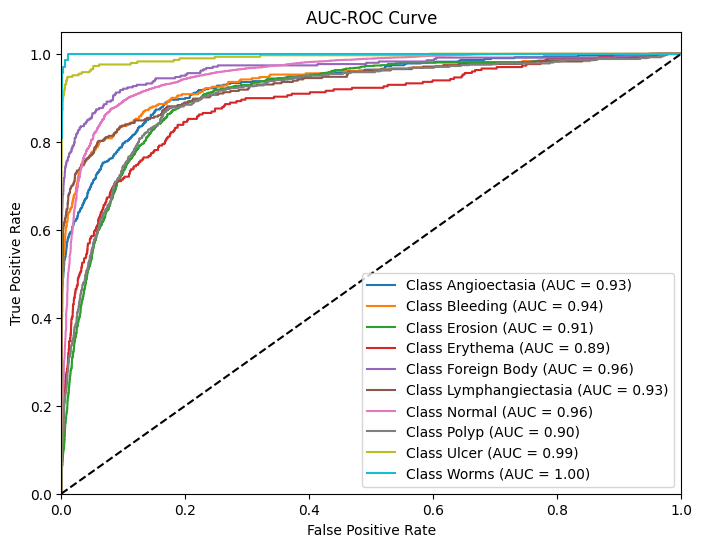

In [21]:
# Plot AUC-ROC curve
lb = LabelBinarizer()
y_val_bin = lb.fit_transform(y_val_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_val_bin[:, i], y_pred[:, i])

# Plot AUC-ROC for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()
